* 起源：主管希望統計近一年每個客戶所買過的商品，統計最多的來做促銷組合，但由於每個客戶購買組合繁多，難以看出最熱銷的組合
* 目的：找出商品採買的關聯性
* 方法：Apriori algorithm

* 參考來源：
    - https://reurl.cc/dnMmdV
    - https://ithelp.ithome.com.tw/m/articles/10217912
    - https://goldinlocks.github.io/Market-Basket-Analysis-in-Python/
    - https://reurl.cc/701MZ5
    - https://www.kaggle.com/code/xvivancos/market-basket-analysis/report

In [17]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder 
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 


import warnings

# Ignore all warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning) # 忽略 'FutureWarning'類別的警告
warnings.filterwarnings('ignore') # 忽略所有警告

# Define a function to ignore warnings
def ignore_warn(*args, **kwargs):
    pass

# Override the warn function with the custom one that ignores warnings
warnings.warn = ignore_warn

## Load Data

In [18]:
df = pd.read_csv('./BreadBasket_DMS.csv')
df

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam
...,...,...,...,...
21288,2017-04-09,14:32:58,9682,Coffee
21289,2017-04-09,14:32:58,9682,Tea
21290,2017-04-09,14:57:06,9683,Coffee
21291,2017-04-09,14:57:06,9683,Pastry


In [19]:
# 清除 Item 是 NONE 的 row
df = df[df['Item'] != 'NONE']

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20507 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         20507 non-null  object
 1   Time         20507 non-null  object
 2   Transaction  20507 non-null  int64 
 3   Item         20507 non-null  object
dtypes: int64(1), object(3)
memory usage: 801.1+ KB


In [21]:
df.shape

(20507, 4)

In [22]:
# # of Item
len(df['Item'].unique())

94

In [23]:
# Item 種類
pd.Series(df.Item).unique()

array(['Bread', 'Scandinavian', 'Hot chocolate', 'Jam', 'Cookies',
       'Muffin', 'Coffee', 'Pastry', 'Medialuna', 'Tea', 'Tartine',
       'Basket', 'Mineral water', 'Farm House', 'Fudge', 'Juice',
       "Ella's Kitchen Pouches", 'Victorian Sponge', 'Frittata',
       'Hearty & Seasonal', 'Soup', 'Pick and Mix Bowls', 'Smoothies',
       'Cake', 'Mighty Protein', 'Chicken sand', 'Coke',
       'My-5 Fruit Shoot', 'Focaccia', 'Sandwich', 'Alfajores', 'Eggs',
       'Brownie', 'Dulce de Leche', 'Honey', 'The BART', 'Granola',
       'Fairy Doors', 'Empanadas', 'Keeping It Local', 'Art Tray',
       'Bowl Nic Pitt', 'Bread Pudding', 'Adjustment', 'Truffles',
       'Chimichurri Oil', 'Bacon', 'Spread', 'Kids biscuit', 'Siblings',
       'Caramel bites', 'Jammie Dodgers', 'Tiffin', 'Olum & polenta',
       'Polenta', 'The Nomad', 'Hack the stack', 'Bakewell',
       'Lemon and coconut', 'Toast', 'Scone', 'Crepes', 'Vegan mincepie',
       'Bare Popcorn', 'Muesli', 'Crisps', 'Pintxos', 

## Data Information

1. Date: 交易的日期（YYYY-MM-DD format），日期範圍從2016/10/30 到 2017/04/09。

2. Time: 交易的時間（HH:MM:SS format）。

3. Transaction: 用於區分交易，相同值的行屬於同一筆交易。

4. Item: 產品名稱。

## Data Analysis

#### Frequency of Most Popular items

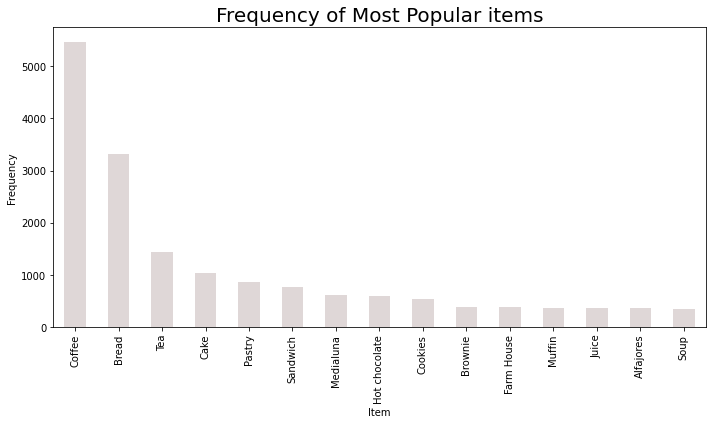

In [24]:
# Calculate item frequencies
item_counts = df['Item'].value_counts().sort_values(ascending=False)

# Select top 15 items
topN = 15

# 每個商品出現的實際次數。
top_items = item_counts.head(topN)

# fig
plt.figure(figsize=(10, 6))
top_items.plot(kind='bar', color='#dfd7d7')
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.title('Frequency of Most Popular items', fontsize = 20)
plt.xticks(rotation=90) # 旋轉 x 軸標籤
plt.tight_layout() # 調整布局，確保圖形元素緊湊排列
plt.show()

銷售排行：1.Coffee 2.Bread 3.Tea

In [25]:
# Date
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['WeekDay'] = df['Date'].dt.day_name()

# Time
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
df['Hour'] = df['Time'].apply(lambda x: x.hour)
df

,Date,Time,Transaction,Item,Month,WeekDay,Hour
0,2016-10-30,09:58:11,1,Bread,10,Sunday,9
1,2016-10-30,10:05:34,2,Scandinavian,10,Sunday,10
2,2016-10-30,10:05:34,2,Scandinavian,10,Sunday,10
3,2016-10-30,10:07:57,3,Hot chocolate,10,Sunday,10
4,2016-10-30,10:07:57,3,Jam,10,Sunday,10
...,...,...,...,...,...,...,...
21288,2017-04-09,14:32:58,9682,Coffee,4,Sunday,14
21289,2017-04-09,14:32:58,9682,Tea,4,Sunday,14
21290,2017-04-09,14:57:06,9683,Coffee,4,Sunday,14
21291,2017-04-09,14:57:06,9683,Pastry,4,Sunday,14


#### Transactions Per Month

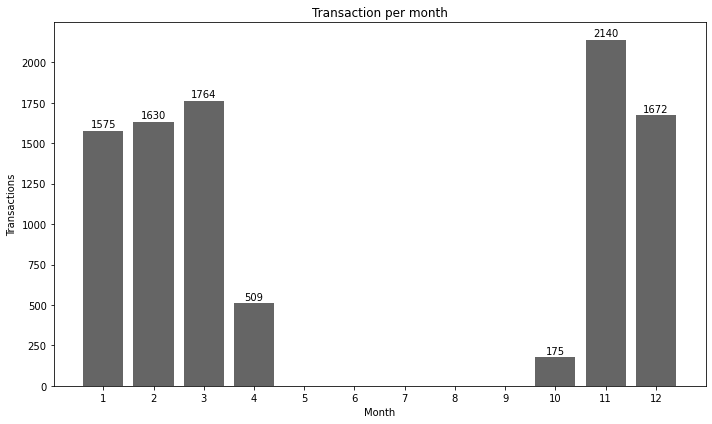

In [26]:
trans_month = df.groupby('Month')['Transaction'].nunique().reset_index()

# fig
plt.figure(figsize=(10, 6))
bar_m = plt.bar(trans_month['Month'], trans_month['Transaction'], color='#656565')
plt.xlabel('Month')
plt.ylabel('Transactions')
plt.title('Transaction per month')
plt.xticks(ticks=range(1, 13), labels=range(1, 13))

# bar 上加數字
for bar in bar_m:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval +10, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

交易量最多前五個月份（多到少）：11月、3月、12月、2月、1月

#### Transactions Per Weekday

In [27]:
df['WeekDay'] = pd.Categorical(df['WeekDay'], categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], ordered=True)
trans_weekday = df.groupby('WeekDay')['Transaction'].nunique().reset_index()
trans_weekday = trans_weekday.sort_values(by='WeekDay')

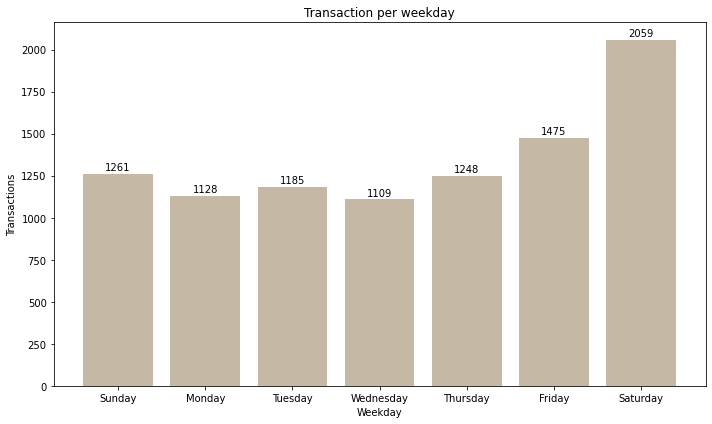

In [28]:
# fig
plt.figure(figsize=(10, 6))
bar_w = plt.bar(trans_weekday['WeekDay'], trans_weekday['Transaction'], color='#c5b8a5')
plt.xlabel('Weekday')
plt.ylabel('Transactions')
plt.title('Transaction per weekday')

for bar in bar_w:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

星期六麵包店最忙，而週三交易量最少。

#### Transactions Per Hour

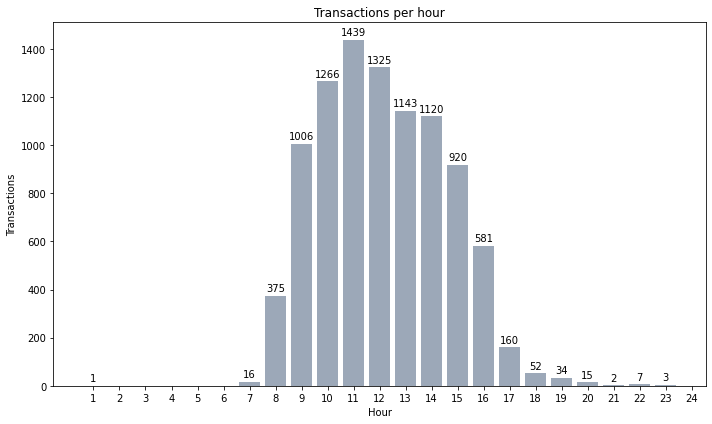

In [29]:
trans_hour = df.groupby('Hour')['Transaction'].nunique().reset_index()

# fig
plt.figure(figsize=(10, 6))
bar_h = plt.bar(trans_hour['Hour'], trans_hour['Transaction'], color='#9ca8b8')
plt.xlabel('Hour')
plt.ylabel('Transactions')
plt.title('Transactions per hour')
plt.xticks(rotation=0)
plt.xticks(ticks=range(1, 25), labels=range(1, 25))

# bar 加數字
for bar in bar_h:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')
    
plt.tight_layout()
plt.show()

交易時間集中於 08 - 17 點

## Transaction Encoding

In [30]:
trans = (df.groupby(['Transaction', 'Item'])['Item']
         .count().unstack().reset_index()
         .fillna(0).set_index('Transaction'))
trans = trans.applymap(lambda x: 1 if x > 0 else 0)
trans

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Apriori Algorithm

#### 支持度（Support）
- 表示物品集在擁有 N 個資料（ALL_DATA）的數據庫中出現的次數比例

In [31]:
# 可以調整 min_support
frequent_itemsets = apriori(trans, min_support = 0.006, use_colnames = True)
rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Coffee),(Alfajores),0.478394,0.036344,0.019651,0.041078,1.130235,0.002264,1.004936,0.220910
1,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
2,(Tea),(Alfajores),0.142631,0.036344,0.006762,0.047407,1.304393,0.001578,1.011614,0.272181
3,(Alfajores),(Tea),0.036344,0.142631,0.006762,0.186047,1.304393,0.001578,1.053339,0.242161
4,(Pastry),(Bread),0.086107,0.327205,0.029160,0.338650,1.034977,0.000985,1.017305,0.036980
...,...,...,...,...,...,...,...,...,...,...
81,(Hot chocolate),"(Coffee, Cake)",0.058320,0.054728,0.006867,0.117754,2.151618,0.003676,1.071438,0.568382
82,"(Coffee, Tea)",(Cake),0.049868,0.103856,0.010037,0.201271,1.937977,0.004858,1.121962,0.509401
83,"(Coffee, Cake)",(Tea),0.054728,0.142631,0.010037,0.183398,1.285822,0.002231,1.049923,0.235157
84,(Tea),"(Coffee, Cake)",0.142631,0.054728,0.010037,0.070370,1.285822,0.002231,1.016827,0.259266


#### 提升度（Lift） & 信賴度（Confidence）

- 提升度（Lift）：
    - 某一個以規則組合出現及單獨出現的比值，公式：confidence(A->B) / support(B) 
    - lift > 1：數據間越相關，呈正相關  
      lift = 1：兩數據獨立，不相關  
      lift < 1：兩數據呈負相關
- 信賴度（Confidence）：在 A 出現的情況下，B 出現的機率

In [35]:
rules[(rules['lift'] > 1.1) & (rules['confidence'] > 0.55)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
29,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
32,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
34,(Salad),(Coffee),0.010460,0.478394,0.006550,0.626263,1.309094,0.001547,1.395648,0.238608
41,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235,0.204851
45,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
78,"(Hot chocolate, Cake)",(Coffee),0.011410,0.478394,0.006867,0.601852,1.258067,0.001409,1.310080,0.207497


關聯性較高的六種組合